### A Simple Bayesian analysis of X-ray spectrum in Sherpa

First import Sherpa 

In [1]:
from sherpa.astro.ui import *

We are only working with spectra, so imaging with ds9 will not be shown. We will use "matplotlib" for visualization. 

Set Poisson likelihood statistics called "cash"in Sherpa and select an optimization method for the initial fit - simplex method which uses nelder-mead algorithm.

In [2]:
set_stat('cash')
set_method('neldermead')

Next load the data, filter and setup a simple absorbed power law model. Note that the calibration files, ARF and RMF,  which are needed for the X-ray analysis and a background fileare read and when the file "acis.pi" is loaded into the session. 

In [3]:
load_data("acis.pi")
ignore(":0.5,7.0:")
set_model(xsphabs.abs1*xspowerlaw.p1)

read ARF file acis.arf
read RMF file acis.rmf
read background file acis_bg.pi


Run the initial fit using simplex and cash. This returns the best fit model parameters, absorption column, power law photon index and normalization.

In [4]:
fit()

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 3.15508e+07
Final fit statistic   = -89797.1 at function evaluation 540
Data points           = 444
Degrees of freedom    = 441
Change in statistic   = 3.16406e+07
   abs1.nH        0.0716477   
   p1.PhoIndex    1.17604     
   p1.norm        0.000533859 


Next get the covariance matrix with covar(). The matrix is later used in the MCMC run.

In [5]:
covar()

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   abs1.nH         0.0716477  -0.00811361   0.00811361
   p1.PhoIndex       1.17604   -0.0242164    0.0242164
   p1.norm       0.000533859 -1.37268e-05  1.37268e-05


Plot the model and the data. 

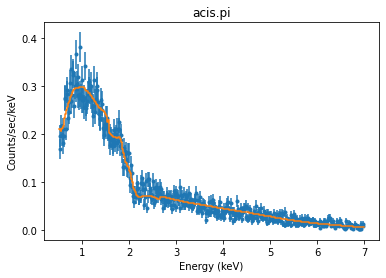

In [6]:
plot_fit()

There are a few samplers in Sherpa that can be used to explore the parameter space. The standard "metropolismh" runs MCMC with Metropolis-Metropolis-Hastings criterium for accepting parameters.

In [7]:
list_samplers()

['metropolismh', 'mh', 'pragbayes', 'fullbayes']

Select MetropolisMH and check the options:

In [8]:
set_sampler("MetropolisMH")
get_sampler()

{'log': False,
 'inv': False,
 'defaultprior': True,
 'priorshape': False,
 'priors': (),
 'originalscale': True,
 'scale': 1,
 'sigma_m': False,
 'p_M': 0.5}

Here we list several options for running the MCMC sampler: 

defaultprior – indicates that all parameters have the default flat prior

inv – indicates which parameters on the inverse scale.

log – indicates which parameters are on the logarithm scale (natural log).

originalscale –  shows that the parameters are on the original scale.

p_M – the proportion of jumps generated by the MCMC jumping rule.

priorshape –  indicates which parameters have user-defined prior functions.

scale – A scalar multiple of the output of covar() used in the scale of the t-distribution


We first run the MCMC with the default settings:

In [9]:
stats, accept, params = get_draws(niter=1e4)
# check the parameters at the minimum statistic value based on the sampler:

Using Priors:
abs1.nH: <function flat at 0x7f9861158670>
p1.PhoIndex: <function flat at 0x7f9861158670>
p1.norm: <function flat at 0x7f9861158670>


In [11]:
bestfit = params[::,stats.argmin()].T
# print bestfit values and standard deviations
print(bestfit)
[params[i].std() for i in [0,1,2]]

[7.16476507e-02 1.17603887e+00 5.33858688e-04]


[0.008107642152592251, 0.024272855895549304, 1.3822923361501428e-05]

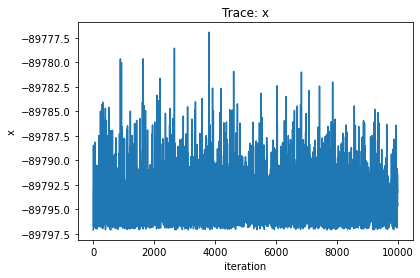

In [12]:
# visualization of the MCMC run - Cash at each iteration
plot_trace(stats)

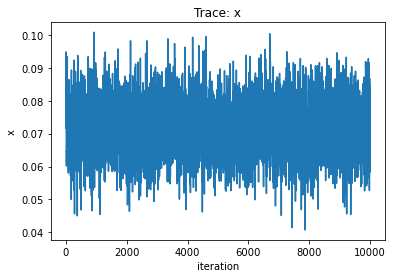

In [13]:
plot_trace(params[0])

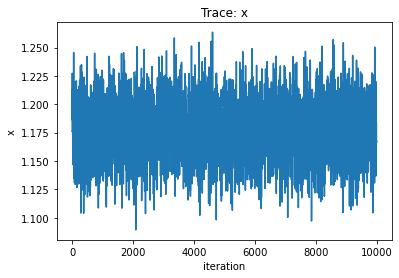

In [14]:
plot_trace(params[1]) 

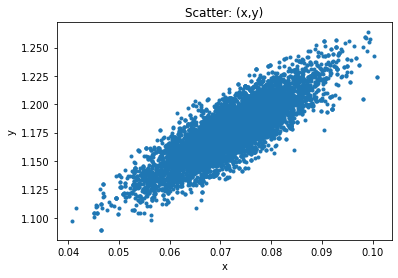

In [15]:
# dependence between parameters
plot_scatter(params[0],params[1])

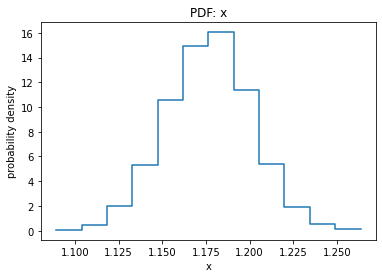

In [16]:
plot_pdf(params[1])

1.1773344599106512
1.2009945016775618
1.1532596821128602


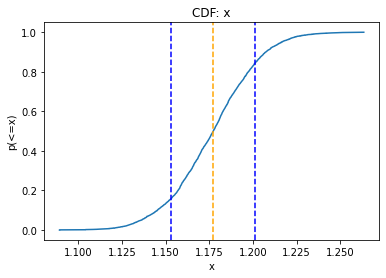

In [18]:
plot_cdf(params[1])
print(get_cdf_plot().median)
print(get_cdf_plot().upper)
print(get_cdf_plot().lower)      

### Effects of Priors

Changing the prior - here an example of prior which has a gaussian shape. We use one of the predefined Sherpa models to set the prior.

In [19]:
normgauss1d.g1
g1.pos=2.
g1.fwhm=0.5
set_prior(p1.PhoIndex,g1)

In [20]:
set_sampler_opt('defaultprior',False)  
set_sampler_opt('priorshape', [False, True, False])  
set_sampler_opt('originalscale', [True, True, True])

In [21]:
#Run sampler
stats, accept, params = get_draws(niter=1e4)

Using Priors:
abs1.nH: <function flat at 0x7f9861158670>
p1.PhoIndex: normgauss1d.g1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   g1.fwhm      thawed          0.5  1.17549e-38  3.40282e+38           
   g1.pos       thawed            2 -3.40282e+38  3.40282e+38           
   g1.ampl      thawed            1 -3.40282e+38  3.40282e+38           
p1.norm: <function flat at 0x7f9861158670>


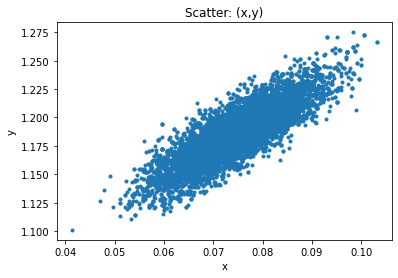

In [22]:
plot_trace(params[1])
plot_scatter(params[0],params[1])

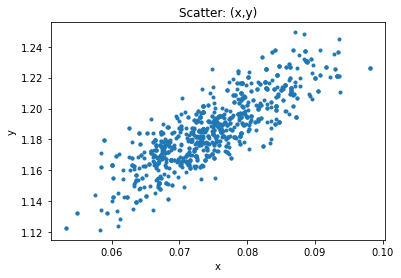

In [23]:
plot_scatter(params[0][1000:2000],params[1][1000:2000])

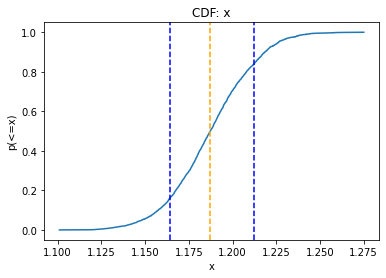

In [24]:
plot_cdf(params[1])